In [1]:
from pathlib import Path
from tbparse import SummaryReader
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
import pickle

In [ ]:
# plt.ion()
# sns.set(font_scale=1, style="white")

In [53]:
df_file = 'dataframe.pd'
if False: # os.path.exists(df_file):
  with open(df_file, 'rb') as f:
    df = pickle.load(f)
else:
  param_list = ["tau_mem", "scale_grad", "width_grad", "optimizer",] # "batch_size", "decoding_func", "encoding_dim", "hidden_dim", "learning_rate", "n_hidden_layers", "spike_threshold"
  dfs = []
  for root, dirs, files in os.walk(Path('lightning_logs/ssc')):
    results = None
    if 'hparams.yaml' in files:
      results = SummaryReader(root, pivot=True)
      df = results.scalars
      hp = results.hparams
      # drop a few columns that we don't use
      # df = df[df.columns[~df.columns.str.endswith("weight_epoch") & ~df.columns.str.endswith("weight_step")]]
      df = df.drop(columns='hp_metric')
      # add hyperparameters to table
      df['method'] = root.split("/")[2].upper() # method name, exodus or slayer
      df['run'] = root.split("/")[-1] # we ran each experiment 3 times, so version_0, 1 or 2
      for param in param_list:
        df[param] = hp[param][0]
      dfs.append(df)
  df = pd.concat(dfs, ignore_index=True)
  df.to_pickle(df_file)

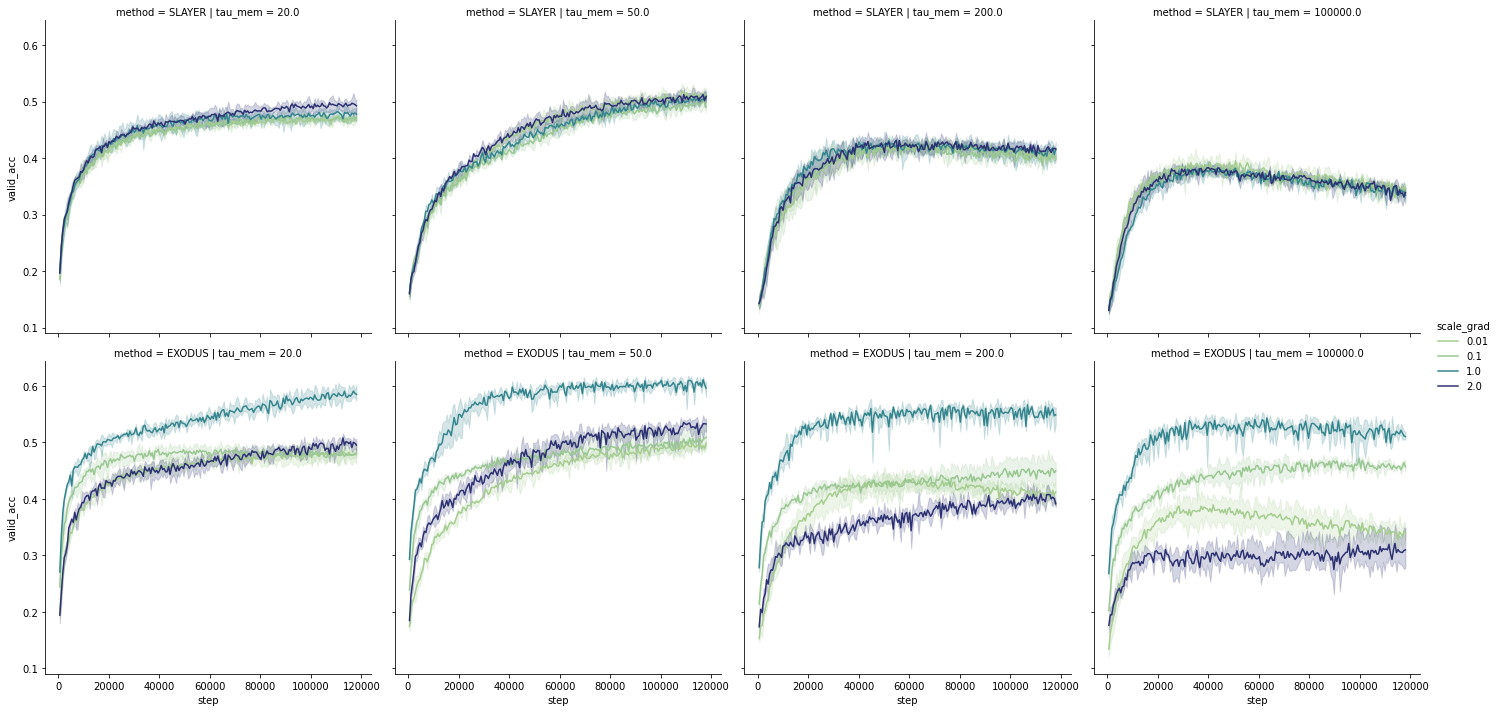

In [54]:
sns.relplot(data=df[df["optimizer"] == "adam"], x="step", y="valid_acc", col="tau_mem", row="method", hue="scale_grad", kind="line", palette="crest")
plt.savefig("results_adam.png")

In [ ]:
sns.relplot(data=df[df["optimizer"] == "sgd"], x="step", y="valid_acc", col="tau_mem", row="method", hue="scale_grad", kind="line", palette="crest")
plt.savefig("results_sgd.png")

In [55]:
df_nolist = df.mask(df.applymap(lambda x: isinstance(x, list)))

In [67]:
irrelevant_cols = ["run", "step", "epoch", "grad_2.0_norm_total_step", "grad_2.0_norm_total_step", ]
val_cols = ["train_loss", "valid_acc", "valid_loss"] + [c for c in df.columns if c.startswith("grad_2.0_norm/")] # and c.endswith("step")]
relevant_identifiers = list(set((c for c in df.columns)).difference(irrelevant_cols + val_cols))

grouped = df_nolist.groupby(relevant_identifiers)
means = grouped.mean()

In [69]:
means.reset_intex()

AttributeError: 'DataFrame' object has no attribute 'ignore_index'

In [46]:
g = sns.FacetGrid(df_nolist, 

,width_grad,method,tau_mem,scale_grad,optimizer,step,grad_2.0_norm_total_epoch,grad_2.0_norm_total_step,train_loss,valid_acc,valid_loss
0,1.0,EXODUS,20.0,0.01,adam,58999.000167,0.612425,0.614766,1.639776,0.449675,1.815816
1,1.0,EXODUS,20.0,0.01,sgd,58999.000167,0.235569,0.236624,3.488741,0.050573,3.485146
2,1.0,EXODUS,20.0,0.10,adam,58999.000167,0.851797,0.854899,1.492199,0.469919,1.745578
3,1.0,EXODUS,20.0,0.10,sgd,58999.000167,0.381629,0.383331,3.387722,0.072271,3.382740
4,1.0,EXODUS,20.0,1.00,adam,58999.000167,11.811982,11.866528,1.446124,0.535255,1.550189
...,...,...,...,...,...,...,...,...,...,...,...
59,1.0,SLAYER,100000.0,0.10,sgd,58999.000167,21.655076,21.823517,3.014497,0.150507,3.004973
60,1.0,SLAYER,100000.0,1.00,adam,58999.000167,32507.493394,32635.225839,2.159099,0.345422,2.232375
61,1.0,SLAYER,100000.0,1.00,sgd,58999.000167,506.260131,504.376808,3.096764,0.136808,3.103477
62,1.0,SLAYER,100000.0,2.00,adam,58999.000167,278857.469193,279385.952639,2.137264,0.350223,2.215131


In [34]:
df_nolists.groupby(relevant_cols).mean()

,,,,,,,,,,,,run
width_grad,step,optimizer,method,tau_mem,scale_grad,grad_2.0_norm_total_step,train_loss,valid_acc,epoch,valid_loss,grad_2.0_norm_total_epoch,
